In [10]:
import pandas as pd
import numpy as np
import json
import itertools
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from random import sample
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import entropy, mannwhitneyu

In [11]:
users = pd.read_csv('../../src/data/distribuitions/hub_bridge_df.csv')
users = users.drop(columns=[
    'external_degree','pct_internal','pct_external',
    'z_internal','betweenness','internal_degree'
])

topics = pd.read_csv('../../src/nlp/topic_modeling/topic_data.csv')
echo_cambers = pd.read_csv('../../src/research_question/echo_chambers_results.csv')

echo_cambers = echo_cambers.drop(columns=['community_type'], errors='ignore')

community_info = users.merge(topics, left_on='id', right_on='author', how='inner').drop(columns=['id_x'])
global_info = community_info.merge(echo_cambers, on='community_id', how='inner', suffixes=('_user', '_echo'))

global_info.head()

,degree,community_id,community_type,is_hub,is_bridge,author,id_y,type,date,lemmatized_text,...,topic_id,num_users,num_hubs,num_bridges,intra_mean,inter_mean,intra_std,inter_std,echo_score,echo_class
0,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,1lyvcd4,post,2025-07-13T15:18:35+00:00,european city local protest amount tourism go ...,...,18,3508,120,174,0.547294,0.43939,0.128893,0.14213,0.38159,Weak/No Echo Chamber
1,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,n2x7kqt,comment,2025-07-13T16:34:29+00:00,talk small percentage people people american e...,...,18,3508,120,174,0.547294,0.43939,0.128893,0.14213,0.38159,Weak/No Echo Chamber
2,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,n2wzdd9,comment,2025-07-13T15:53:01+00:00,ism true issue government handle see would end...,...,0,3508,120,174,0.547294,0.43939,0.128893,0.14213,0.38159,Weak/No Echo Chamber
3,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,n2x722x,comment,2025-07-13T16:31:51+00:00,still owner choose tourist local certain area ...,...,18,3508,120,174,0.547294,0.43939,0.128893,0.14213,0.38159,Weak/No Echo Chamber
4,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,n2x69bh,comment,2025-07-13T16:27:46+00:00,visitor stay permanently typically tourist wou...,...,18,3508,120,174,0.547294,0.43939,0.128893,0.14213,0.38159,Weak/No Echo Chamber


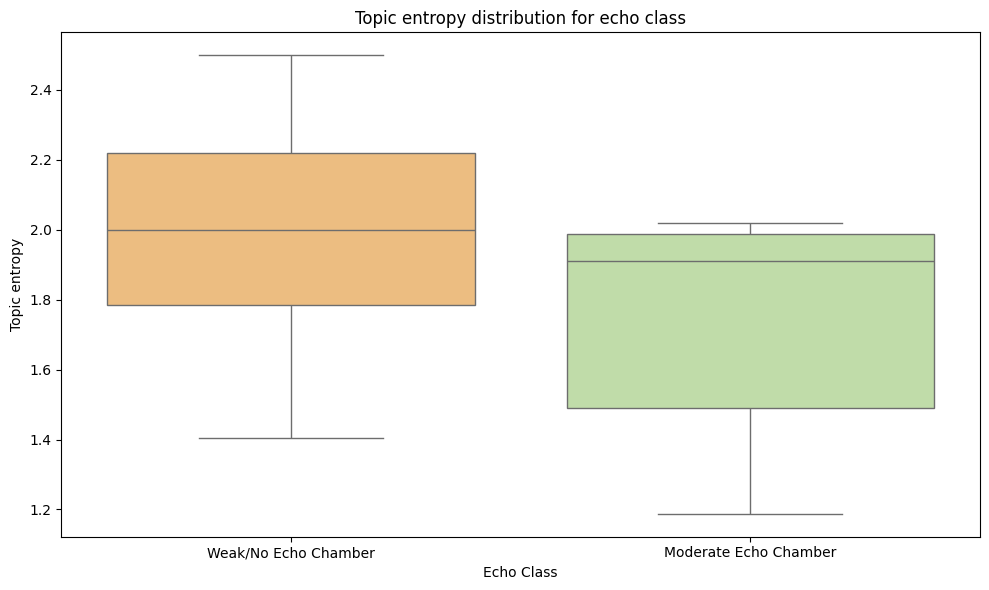

In [12]:
# Topic diversity in echo chambers - entropy
community_topic_counts = pd.read_csv('../../src/nlp/topic_modeling/community_topic_counts.csv')

community_topic_counts_with_type = community_topic_counts.merge(
    global_info[['community_id', 'echo_class']].drop_duplicates(),
    on='community_id',
    how='left'
)

topic_diversity = community_topic_counts_with_type.groupby('community_id').agg({
    'count': lambda x: entropy(x/x.sum()),
    'echo_class': 'first'
}).reset_index().rename(columns={'count': 'topic_entropy'})


plt.figure(figsize=(10, 6))
sns.boxplot(data=topic_diversity, x='echo_class', hue='echo_class', y='topic_entropy', palette="Spectral")

counts = topic_diversity.groupby('echo_class')['community_id'].nunique()
for i, ct in enumerate(topic_diversity['echo_class'].unique()):
    n = counts.get(ct, 0)
plt.title("Topic entropy distribution for echo class")
plt.xlabel("Echo Class")
plt.ylabel("Topic entropy")
plt.tight_layout()
plt.show()

Plotting topics distribuition in Echo Chambers

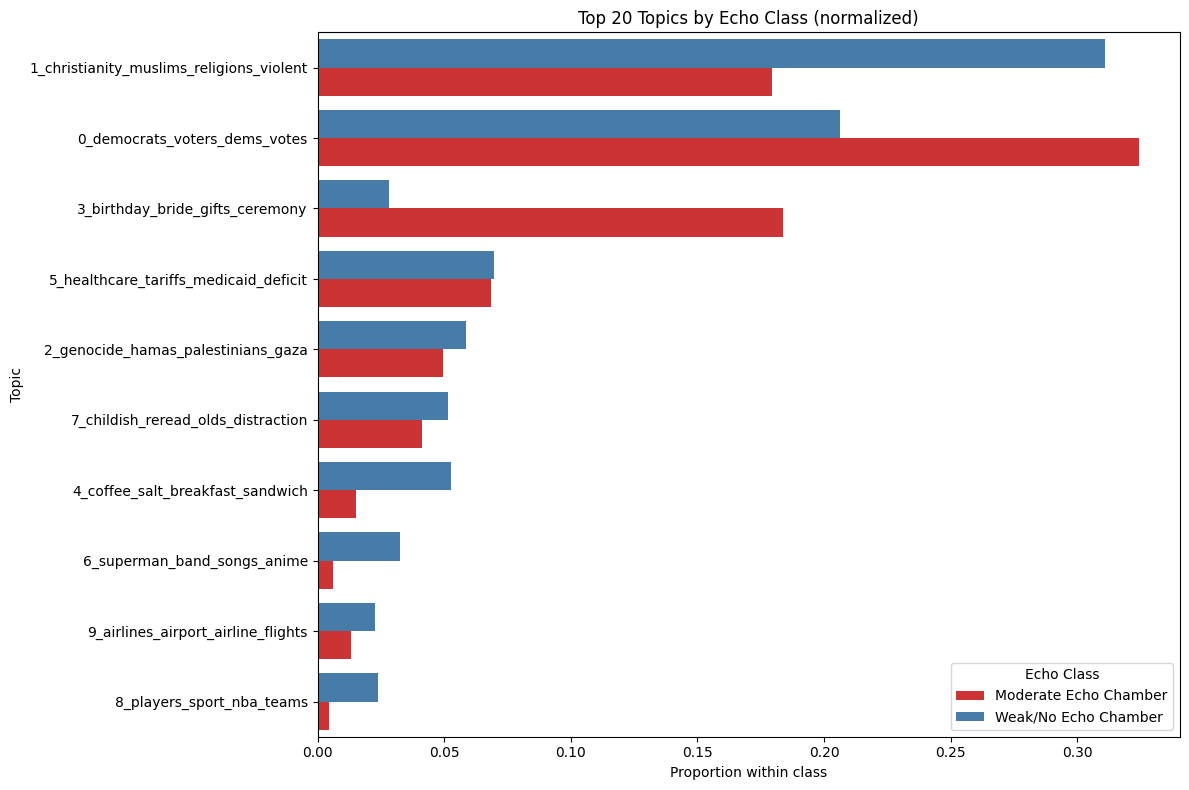

In [19]:
# Distribuzione normalizzata per classe
topic_counts = (
    global_info.groupby(['echo_class', 'topic'])
      .size()
      .reset_index(name='count')
)

# Calcolo percentuale all’interno di ogni classe
topic_counts['pct'] = (
    topic_counts.groupby('echo_class')['count']
    .transform(lambda x: x / x.sum())
)

#  Selezione dei top 20 topic globali (basati sui conteggi totali, non sulle percentuali)
top_topics = (
    topic_counts.groupby('topic')['count']
    .sum()
    .nlargest(10)
    .index
)

topic_counts = topic_counts[topic_counts['topic'].isin(top_topics)]
topic_order = (
    topic_counts.groupby('topic')['count']
    .sum()
    .sort_values(ascending=True)
    .index
)

# --- Plot ---
plt.figure(figsize=(12,8))
sns.barplot(
    data=topic_counts,
    y='topic', x='pct', hue='echo_class',
    orient='h', palette='Set1',
    order=topic_order
)

plt.ylabel("Topic")
plt.xlabel("Proportion within class")
plt.title("Top 20 Topics by Echo Class (normalized)")
plt.gca().invert_yaxis()
plt.legend(title="Echo Class")
plt.tight_layout()
plt.show()


In [14]:
temporal_dataset = pd.read_csv('../../src/nlp/cleaned_dataset.csv')
temporal_dataset = temporal_dataset.drop(columns=['type', 'clean_text'], errors='ignore')

global_info = global_info.merge(temporal_dataset, left_on='id_y', right_on='id', how='left' )

In [15]:
# Retrieving post by month
global_info['date_x'] = pd.to_datetime(global_info['date_x'], utc=True)
global_info['month'] = global_info['date_x'].dt.to_period('M').dt.to_timestamp()
global_info.head()

/tmp/ipykernel_13971/2653248553.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  global_info['month'] = global_info['date_x'].dt.to_period('M').dt.to_timestamp()


,degree,community_id,community_type,is_hub,is_bridge,author_x,id_y,type,date_x,lemmatized_text_x,...,inter_mean,intra_std,inter_std,echo_score,echo_class,author_y,id,date_y,lemmatized_text_y,month
0,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,1lyvcd4,post,2025-07-13 15:18:35+00:00,european city local protest amount tourism go ...,...,0.43939,0.128893,0.14213,0.38159,Weak/No Echo Chamber,-Dead-Eye-Duncan-,1lyvcd4,2025-07-13T15:18:35+00:00,european city local protest amount tourism go ...,2025-07-01
1,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,n2x7kqt,comment,2025-07-13 16:34:29+00:00,talk small percentage people people american e...,...,0.43939,0.128893,0.14213,0.38159,Weak/No Echo Chamber,-Dead-Eye-Duncan-,n2x7kqt,2025-07-13T16:34:29+00:00,talk small percentage people people american e...,2025-07-01
2,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,n2wzdd9,comment,2025-07-13 15:53:01+00:00,ism true issue government handle see would end...,...,0.43939,0.128893,0.14213,0.38159,Weak/No Echo Chamber,-Dead-Eye-Duncan-,n2wzdd9,2025-07-13T15:53:01+00:00,ism true issue government handle see would end...,2025-07-01
3,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,n2x722x,comment,2025-07-13 16:31:51+00:00,still owner choose tourist local certain area ...,...,0.43939,0.128893,0.14213,0.38159,Weak/No Echo Chamber,-Dead-Eye-Duncan-,n2x722x,2025-07-13T16:31:51+00:00,still owner choose tourist local certain area ...,2025-07-01
4,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,n2x69bh,comment,2025-07-13 16:27:46+00:00,visitor stay permanently typically tourist wou...,...,0.43939,0.128893,0.14213,0.38159,Weak/No Echo Chamber,-Dead-Eye-Duncan-,n2x69bh,2025-07-13T16:27:46+00:00,visitor stay permanently typically tourist wou...,2025-07-01


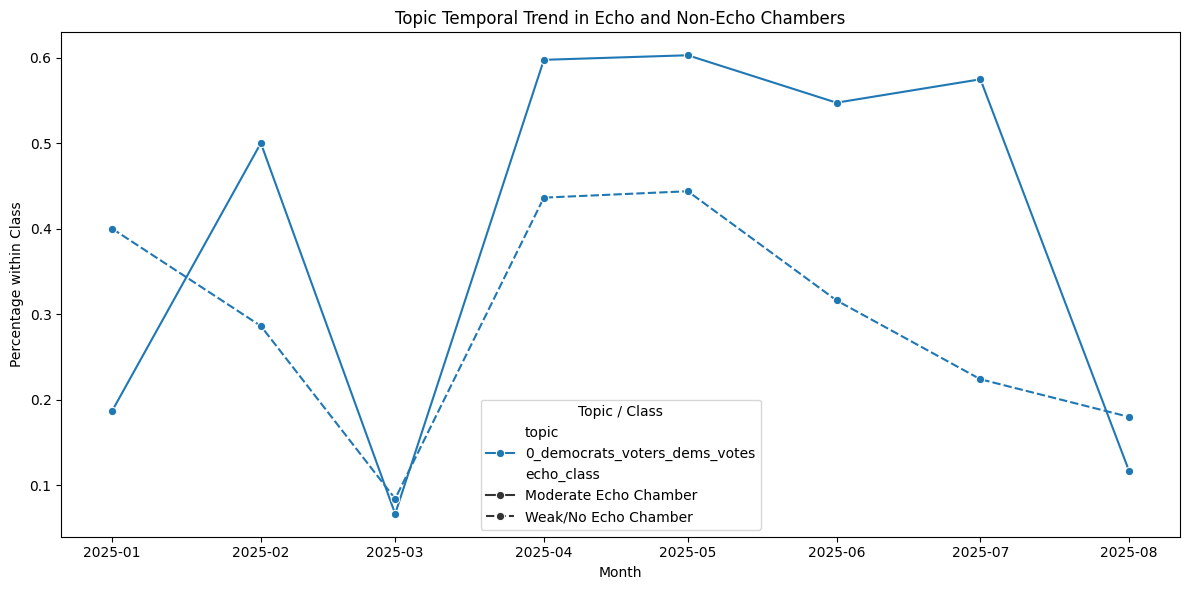

In [16]:
# Frequenza per (classe, topic, mese)
topic_time = (
    global_info.groupby(['echo_class', 'topic', 'month'])
    .size()
    .reset_index(name='count')
)

# Normalizzazione: % sul totale per classe e mese
topic_time['pct'] = (
    topic_time.groupby(['echo_class', 'month'])['count']
    .transform(lambda x: x / x.sum())
)

# Selezioniamo i top 5 topic più frequenti nelle echo
top_topics = (
    topic_time[topic_time['echo_class'] == "Moderate Echo Chamber"]
    .groupby('topic')['count']
    .sum()
    .nlargest(1)
    .index
)

plot_data = topic_time[topic_time['topic'].isin(top_topics)]

# Plot lineare
plt.figure(figsize=(12,6))
sns.lineplot(
    data=plot_data,
    x='month',
    y='pct',
    hue='topic',
    style='echo_class',
    marker="o"
)
plt.title("Topic Temporal Trend in Echo and Non-Echo Chambers")
plt.xlabel("Month")
plt.ylabel("Percentage within Class")
plt.legend(title="Topic / Class")
plt.tight_layout()
plt.show()


## Sentiment and emotional analysis of echo chambers

In [17]:
sentiments = pd.read_csv('../../src/nlp/sentiment/sentiment_scores.csv')
global_info = global_info.merge(sentiments, left_on='id_y', right_on='id', how='left' )
global_info.head()

,degree,community_id,community_type,is_hub,is_bridge,author_x,id_y,type,date_x,lemmatized_text_x,...,date_y,lemmatized_text_y,month,author,id_y,model,neg_percentage,neu_percentage,pos_percentage,predicted_sentiment
0,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,1lyvcd4,post,2025-07-13 15:18:35+00:00,european city local protest amount tourism go ...,...,2025-07-13T15:18:35+00:00,european city local protest amount tourism go ...,2025-07-01,-Dead-Eye-Duncan-,1lyvcd4,bertweet,0.418683,0.574122,0.007195,neutral
1,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,n2x7kqt,comment,2025-07-13 16:34:29+00:00,talk small percentage people people american e...,...,2025-07-13T16:34:29+00:00,talk small percentage people people american e...,2025-07-01,-Dead-Eye-Duncan-,n2x7kqt,bertweet,0.888771,0.108072,0.003158,negative
2,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,n2wzdd9,comment,2025-07-13 15:53:01+00:00,ism true issue government handle see would end...,...,2025-07-13T15:53:01+00:00,ism true issue government handle see would end...,2025-07-01,-Dead-Eye-Duncan-,n2wzdd9,bertweet,0.461445,0.532365,0.006190,neutral
3,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,n2x722x,comment,2025-07-13 16:31:51+00:00,still owner choose tourist local certain area ...,...,2025-07-13T16:31:51+00:00,still owner choose tourist local certain area ...,2025-07-01,-Dead-Eye-Duncan-,n2x722x,bertweet,0.075434,0.911569,0.012997,neutral
4,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,n2x69bh,comment,2025-07-13 16:27:46+00:00,visitor stay permanently typically tourist wou...,...,2025-07-13T16:27:46+00:00,visitor stay permanently typically tourist wou...,2025-07-01,-Dead-Eye-Duncan-,n2x69bh,bertweet,0.048019,0.850175,0.101806,neutral


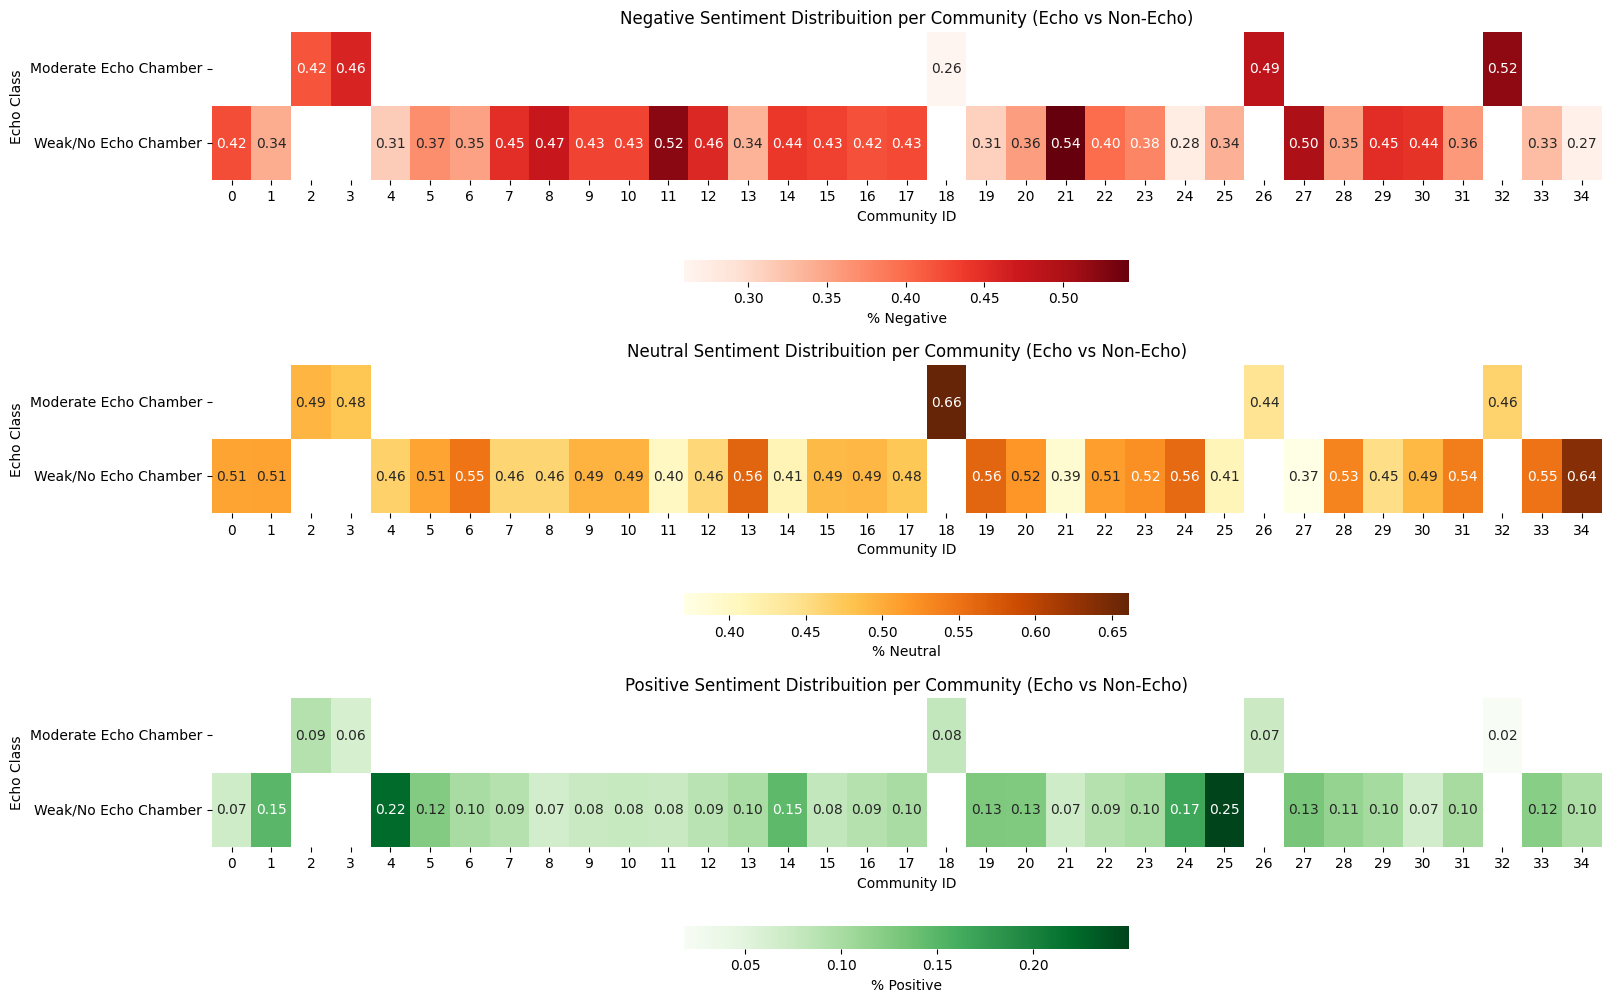

In [18]:
sentiment_stats = global_info.groupby(['community_id', 'echo_class']).agg(
    Negative=('neg_percentage', 'mean'),
    Neutral=('neu_percentage', 'mean'),
    Positive=('pos_percentage', 'mean')
).reset_index()

# Step 2: Normalizzazione interna (ogni community = 100%)
sentiment_stats[['Negative', 'Neutral', 'Positive']] = sentiment_stats[['Negative', 'Neutral', 'Positive']].div(
    sentiment_stats[['Negative', 'Neutral', 'Positive']].sum(axis=1), axis=0
)

# Lista sentimenti e colormap dedicate
sentiments = {
    'Negative': 'Reds',
    'Neutral': 'YlOrBr',
    'Positive': 'Greens'
}

fig, axes = plt.subplots(3, 1, figsize=(16, 10), constrained_layout=True)

for i, (sentiment, cmap) in enumerate(sentiments.items()):
    # Pivot: echo_class come riga, community come colonna
    heatmap_data = sentiment_stats.pivot(
        index='echo_class', 
        columns='community_id', 
        values=sentiment
    )
    
    # Heatmap
    sns.heatmap(
        heatmap_data, 
        cmap=cmap, 
        annot=True, 
        fmt=".2f", 
        ax=axes[i],
        cbar_kws={'orientation': 'horizontal', 'shrink': 0.6, 'pad': 0.2, 'label': f"% {sentiment}"}
    )
    
    # Titolo
    axes[i].set_title(f"{sentiment} Sentiment Distribuition per Community (Echo vs Non-Echo)", fontsize=12)
    axes[i].set_xlabel("Community ID")
    axes[i].set_ylabel("Echo Class")

plt.show()